<a href="https://colab.research.google.com/github/fralfaro/MAT281_2023/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

<a id='p1'></a>
## I.- Problema 01

Lista de actos delictivos registrados por el Service de police de la Ville de Montréal (SPVM).


<img src="http://henriquecapriles.com/wp-content/uploads/2017/02/femina_detenida-1080x675.jpg" width="480" height="360" align="center"/>

El conjunto de datos en estudio `interventionscitoyendo.csv` corresponde a  todos los delitos entre 2015 y agosto de 2020en Montreal. Cada delito está asociado en grandes categorías, y hay información sobre la ubicación, el momento del día, etc.

> **Nota**: Para más información seguir el siguiente el [link](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).

In [1]:
# librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# graficos incrustados
sns.set_style('whitegrid')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def regression_metrics(df):
    """
    Aplicar las distintas métricas definidas
    :param df: DataFrame con las columnas: ['y', 'yhat']
    :return: DataFrame con las métricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mean_absolute_error(y_true, y_pred), 4)]
    df_result['mse'] = [round(mean_squared_error(y_true, y_pred), 4)]
    df_result['rmse'] = [round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)]
    df_result['mape'] = [round(mean_absolute_percentage_error(y_true, y_pred), 4)]
    df_result['smape'] = [round(2 * mean_absolute_percentage_error(y_true, y_pred) / (mean_absolute_percentage_error(y_true, y_pred) + 100), 4)]

    return df_result

In [3]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281_2022/main/labs/lab_10/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [4]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()

El objetivo de este laboratorio es poder realizar un análisis completo del conjunto de datos en estudio, para eso debe responder las siguientes preguntas:

1. Realizar un gráfico para cada serie temporal $y\_{si}, i =1,2,3,4$.


In [5]:
#Creamos los títulos de los gráficos, solo para tener coherencia con los datos
Titulos1=str(validate_categorie[0])
Titulos2=str(validate_categorie[1])
Titulos3=str(validate_categorie[2])
Titulos4=str(validate_categorie[3])

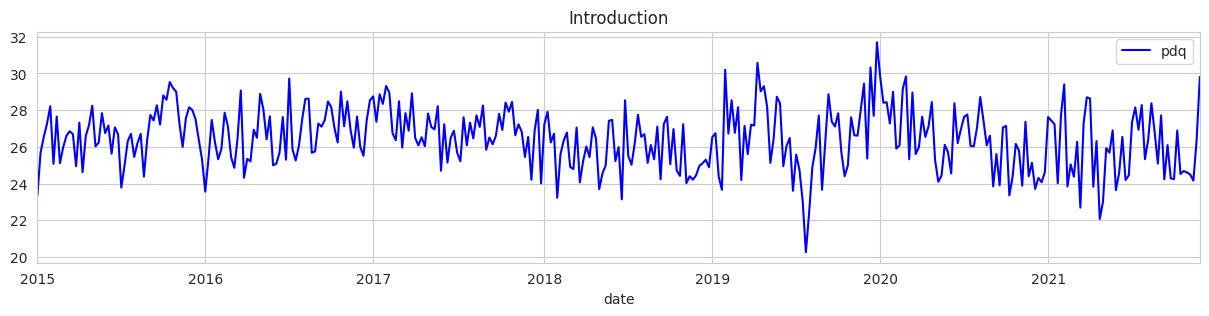

In [6]:
# graficar datos
y_s1.plot(figsize=(15, 3),color = 'blue')
plt.title(Titulos1)
plt.show()

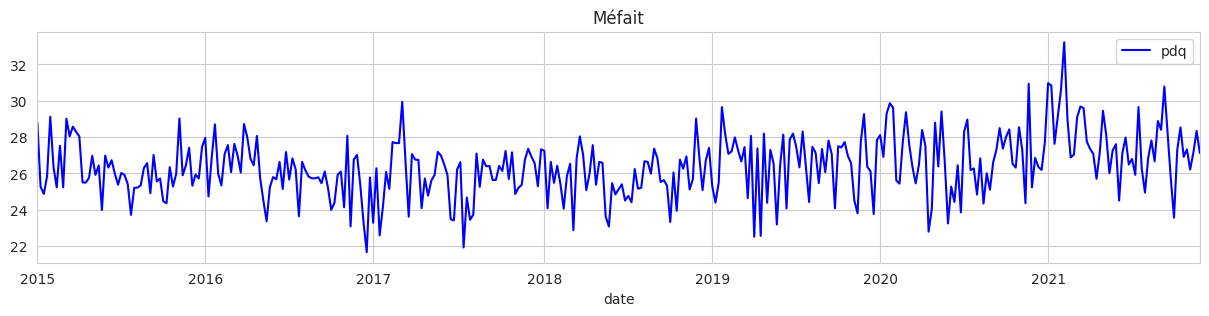

In [8]:
y_s2.plot(figsize=(15, 3),color = 'blue')
plt.title(Titulos2)
plt.show()

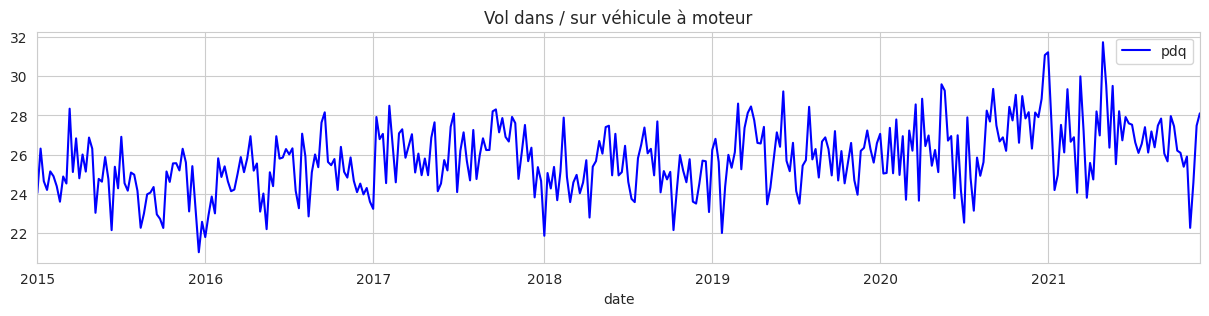

In [9]:
y_s3.plot(figsize=(15, 3),color = 'blue')
plt.title(Titulos3)
plt.show()

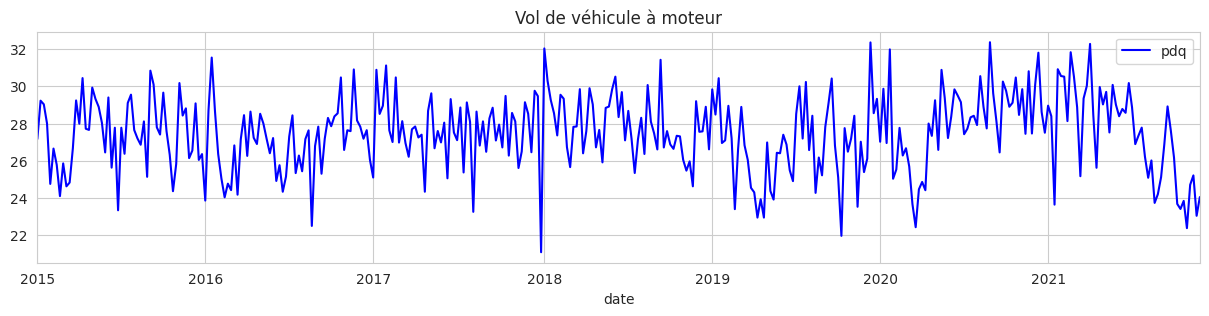

In [10]:
y_s4.plot(figsize=(15, 3),color = 'blue')
plt.title(Titulos4)
plt.show()

2. Escoger alguna serie temporal $y\_{si}, i =1,2,3,4$. Luego:

* Realizar un análisis exploratorio de la serie temporal escogida
* Aplicar el modelo de pronóstico $SARIMA(p,d,q)x(P,D,Q,S)$, probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.
* Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.

> **Hint**: Tome como `target_date` =  '2021-01-01'. Recuerde considerar que su columna de valores se llama `pdq`.


In [11]:
# Creando la clase SarimaModels
class SarimaModels:
    def __init__(self, params):
        self.params = params

    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ', '')

    @staticmethod
    def test_train_model(y, date):
        mask_ds = y.index < date
        y_train = y[mask_ds]
        y_test = y[~mask_ds]
        return y_train, y_test

    def fit_model(self, y, date):
        y_train, y_test = self.test_train_model(y, date)
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=0)
        return model_fit

    def df_testing(self, y, date):
        y_train, y_test = self.test_train_model(y, date)
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=0)
        start_index = y_test.index.min()
        end_index = y_test.index.max()
        preds = model_fit.get_prediction(start=start_index, end=end_index, dynamic=False)
        df_temp = pd.DataFrame({
            'y': y_test['pdq'],
            'yhat': preds.predicted_mean
        })
        return df_temp

    def metrics(self, y, date):
        df_temp = self.df_testing(y, date)
        df_metrics = regression_metrics(df_temp)
        df_metrics['model'] = self.name_model
        return df_metrics

# Definir parámetros
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
params = list(itertools.product(pdq, seasonal_pdq))
target_date = '2021-01-01'

Análisis de Datos: MÉFAIT

In [12]:
#Se puede hacer un resumen de los datos
y_s2.describe()

,pdq
count,361.000000
mean,26.389151
std,1.677889
min,21.660870
25%,25.371134
50%,26.406250
75%,27.361538
max,33.220588


In [13]:
#Podemos ver cuántos
y_s2.isnull().sum()

pdq    0
dtype: int64

In [14]:
#Podemos ver cuántos datos únicos hay
y_s2['pdq'].nunique()

356

__Aplicar modelo de pronóstico__ SARIMA(p,d,q)x(P,D,Q,S)

In [15]:
# iterar para los distintos escenarios

frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        df_metrics = sarima_model.metrics(y_s2,target_date)
        frames.append(df_metrics)
    except:
        pass

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
# juntar resultados de las métricas y comparar
df_metrics_result = pd.concat(frames)
df_metrics_result.sort_values(['mae','mape'])

,mae,mse,rmse,mape,smape,model
0,1.3551,3.4263,1.8510,4.7784,0.0912,"SARIMA_(1,1,0)X(1,0,1,12)"
0,1.3567,3.4359,1.8536,4.7836,0.0913,"SARIMA_(1,1,0)X(0,0,1,12)"
0,1.3584,3.4565,1.8592,4.7871,0.0914,"SARIMA_(1,1,0)X(1,0,0,12)"
0,1.3588,3.5038,1.8718,4.7826,0.0913,"SARIMA_(1,1,0)X(0,0,0,12)"
0,1.3703,3.1981,1.7883,4.9104,0.0936,"SARIMA_(0,1,0)X(0,0,0,12)"
...,...,...,...,...,...,...
0,3.1468,13.4226,3.6637,11.0671,0.1993,"SARIMA_(1,1,0)X(1,1,0,12)"
0,24.1010,618.8685,24.8771,87.4354,0.9330,"SARIMA_(0,0,0)X(0,0,1,12)"
0,24.5214,625.0162,25.0003,88.9315,0.9414,"SARIMA_(0,0,1)X(0,0,1,12)"
0,27.5504,762.9708,27.6219,99.3162,0.9966,"SARIMA_(0,0,1)X(0,0,0,12)"


In [20]:
# ajustar mejor modelo

param = [(1,1,0),(0,1,1,12)]
sarima_model =  SarimaModels(param)
model_fit = sarima_model.fit_model(y_s2,target_date)
best_model = sarima_model.df_testing(y_s2,target_date)
best_model.head()

,y,yhat
2021-01-03,30.967742,26.538365
2021-01-10,30.833333,26.484319
2021-01-17,27.629032,26.865223
2021-01-24,29.114754,27.174432
2021-01-31,30.606061,27.088550


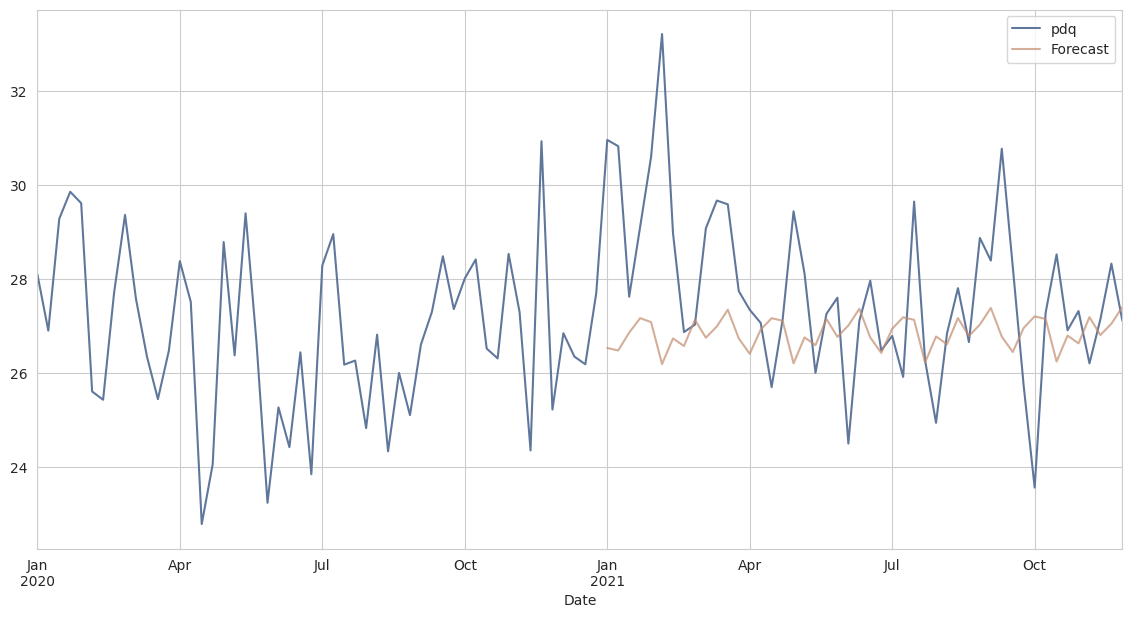

In [21]:
# graficar mejor modelo

preds = best_model['yhat']
ax = y_s2['2020':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
plt.legend()
plt.show()

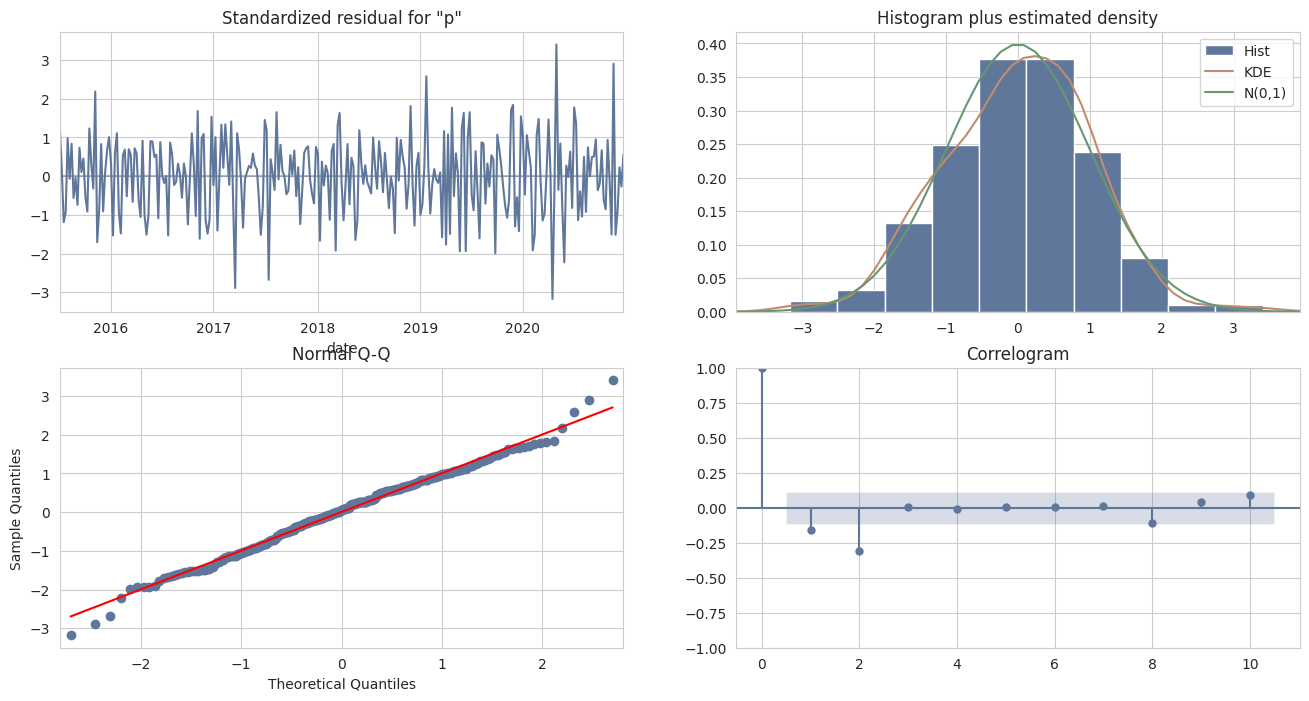

In [22]:
# resultados del error
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()



Finalmente, podemos verificar, gracias a la información proporcionada al apartado anterior, que estamos frente a ruido blanco. Esto pues:

  1. Podemos notar que en el histograma se crea una campana de gauss simétrica en torno al 0, característica del ruido blanco.
  2. En el primer gráfico, la serie de tiempo corresponde a una serie estacionaria que oscila entorno al cero, es decir, un ruido blanco



3. Resuelva el ejercicio anterior utilizando la librería de `Prophet`.

In [23]:
from prophet import Prophet

In [24]:
mask_ds = y_s2.index < target_date
y_train = y_s2[mask_ds]
y_test = y_s2[~mask_ds]
# rename
y_train_prophet = y_train.reset_index()
y_train_prophet.columns = ["ds","y"]

y_test_prophet = y_test.reset_index()
y_test_prophet.columns = ["ds","y"]

In [25]:
# model
m = Prophet()
m.fit(y_train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoty443e3/4i9qikf_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoty443e3/fyytj4fr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7886', 'data', 'file=/tmp/tmpoty443e3/4i9qikf_.json', 'init=/tmp/tmpoty443e3/fyytj4fr.json', 'output', 'file=/tmp/tmpoty443e3/prophet_modelxu448_o8/prophet_model-20231120132353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [26]:
# forecast
future = m.make_future_dataframe(periods=365*4)
forecast = m.predict(future)[['ds', 'yhat']]
forecast.tail()

,ds,yhat
1768,2024-12-22,28.216945
1769,2024-12-23,28.230606
1770,2024-12-24,28.252194
1771,2024-12-25,28.281111
1772,2024-12-26,28.316615


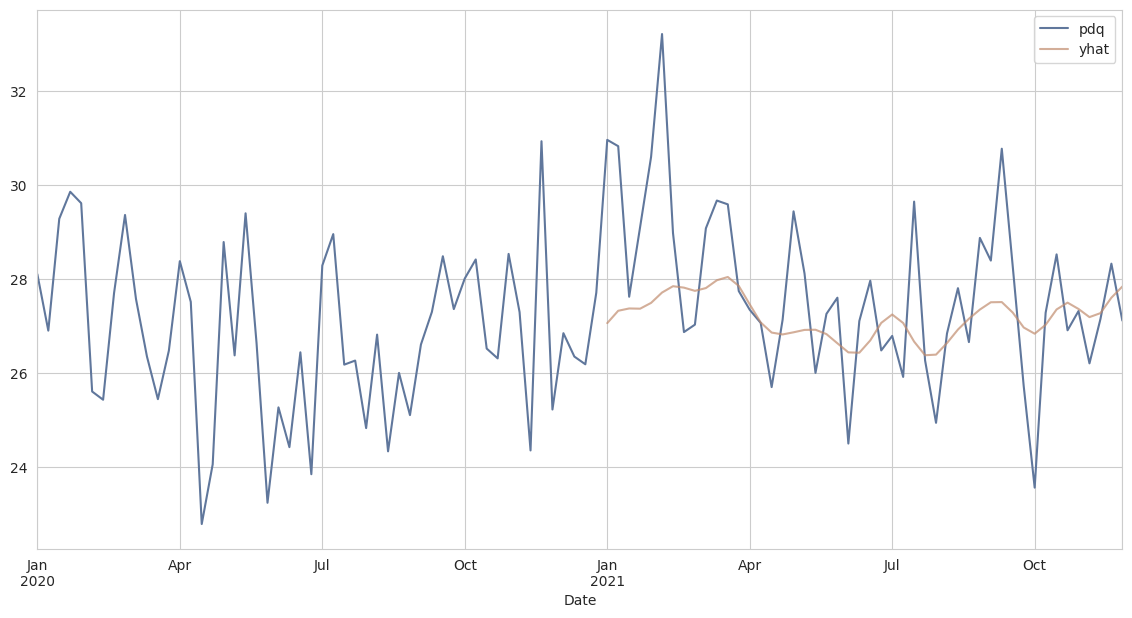

In [29]:
preds = result[['ds','yhat']].set_index("ds")
ax = y_s2['2020':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

ax.set_xlabel('Date')
plt.legend()
plt.show()